In [2]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [3]:
from proj1_helpers import *
from toolbox import *
DATA_TRAIN_PATH = 'train.csv' # TODO: download train data and supply path here 
init_y, init_x, ids = load_csv_data(DATA_TRAIN_PATH, sub_sample=False)
init_y = (init_y + 1.0) * 0.5

## Contains all our main methods
When you add your own methods, please add a short description so that we all know what it does

In [75]:
def cropped_of_rows_with_999_value(x, y):
    """Returns updated x and y such that all row which contained
       at least one value = -999 are removed"""
    for i in range(x.shape[1]):
        idxes = (x[:, i] != -999)
        x = x[idxes]
        y = y[idxes]
    return x, y

def columns_with_999_value(x):
    """Returns the indices of all the columns which have at least one element = -999"""
    indexes = []
    for i in range(x.shape[1]):
        if np.any(x[:, i] == -999):
            indexes.append(i)
    return indexes

def column_mean_without_999(col):
    return np.mean(col[col[:] != -999])

def replace_999_with(col, val):
    col[col[:] == -999] = val

def columns_with_low_corr(x, y):
    """Returns the indices of the columns which have a 
       'low' correlation to the output. (Experimental)"""
    indexes = []
    for i in range(x.shape[1]):
        if np.abs(np.corrcoef(x[:, i], y)[0][1]) < 0.03:
            indexes.append(i)
    return indexes

def cropped_of_columns(x, columns_indexes):
    """Returns a copy of x where the columns indexed by columns_indices are removed"""
    return np.delete(x, columns_indexes, axis = 1)

def augment(x, n):
    """Returns x concatenated with x ** 2, ..., x ** n"""
    return x if n == 1 else np.append(augment(x, n - 1), x ** n, axis = 1)

## Transform `x` and `y` as you want here using the functions above

In [76]:
# Try your own transformations here

# IF YOU DO TRANSFORMATIONS WHICH AFFECT THE SHAPE OF X, DON'T FORGET TO
# MAKE THE SAME TRANSFORMATIONS ON X_TEST AT THE END

#rem_indices_1 = columns_with_999_value(init_x)
#rem_indices_1.remove(0)
#x = cropped_of_columns(init_x, rem_indices_1)

#print(rem_indices_1)

#rem_indices_2 = columns_with_low_corr(x, y) # []

x, y = init_x, init_y

for i in range(x.shape[1]):
    col = x[:, i]
    mean = column_mean_without_999(col)
    replace_999_with(col, mean)
    
#x, y = cropped_of_rows_with_999_value(init_x, init_y)
x = augment(x, 6)


## Standardize

In [77]:
tx, mean, var = standardize(x)

print(tx.shape)

(250000, 181)


## Visualizations

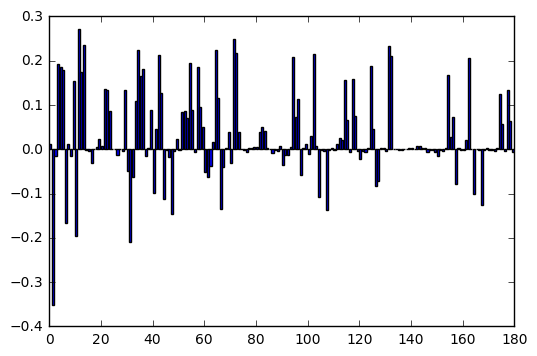

In [78]:
def plot_feature_to_output_correlations(x, y):
    feature_count = x.shape[1]

    corrs = np.zeros(feature_count)
    for i in range(feature_count):
        feature = x[:, i]
        corrs[i] = np.corrcoef(feature, y)[0][1]

    fig, ax = plt.subplots()
    width = 0.5

    ax.bar(np.arange(feature_count), corrs)

plot_feature_to_output_correlations(x, y)

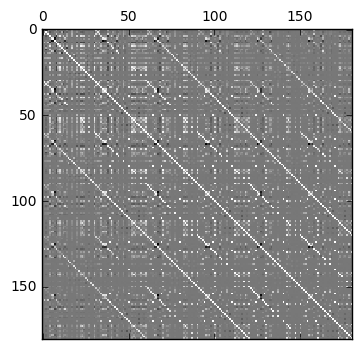

In [79]:
G = tx.T @ tx
plt.matshow(G, cmap=plt.cm.gray)

## Cross validation

In [87]:
def predict(tx, w):
    """Predicts the output"""
    y_pred = expit(tx @ w)

    y_pred[y_pred <  0.5] = 0
    y_pred[y_pred >= 0.5] = 1

    return y_pred

def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def cross_validation(y, tx, k_indices, k):
    """return the loss of ridge regression."""
    tmp_y = np.delete(y[k_indices], k, 0)
    tmp_x = np.delete(tx[k_indices], k, 0)
    train_y = tmp_y.reshape(tmp_y.shape[0] * tmp_y.shape[1])
    train_x = tmp_x.reshape((tmp_x.shape[0] * tmp_x.shape[1], tmp_x.shape[2]))
    test_y  = y[k_indices[k]]
    test_x  = tx[k_indices[k]]
    
    loss, w = logistic_regression(train_y, train_x, np.zeros(train_x.shape[1]), 0.7, 70000)
    
    train_y_pred = predict(train_x, w)
    test_y_pred  = predict(test_x,  w)

    train_y_err = np.count_nonzero(train_y_pred == train_y) / len(train_y)
    test_y_err  = np.count_nonzero(test_y_pred  == test_y ) / len(test_y)
    
    return train_y_err, test_y_err

k_fold = 4
k_indices = build_k_indices(y, k_fold, 1)
for k in range(k_fold):
    train_err, test_err = cross_validation(y, tx, k_indices, k)
    print("#%s fold: (Train error: %s, Test error: %s)" % (k, train_err, test_err))

#0 fold: (Train error: 0.8122613333333333, Test error: 0.813648)
#1 fold: (Train error: 0.8110986666666666, Test error: 0.808144)
#2 fold: (Train error: 0.8090613333333333, Test error: 0.809296)
#3 fold: (Train error: 0.8113653333333334, Test error: 0.811632)


## Learning phase

In [88]:
loss, w = logistic_regression(y, tx, np.zeros(tx.shape[1]), 0.7, 50000)

## Test predictions against train set output

In [89]:
y_pred_train = predict(tx, w)

np.count_nonzero(y_pred_train == y) / len(y)

0.80912

## Generate predictions and save ouput in csv format for submission:

In [11]:
DATA_TEST_PATH = 'test.csv' # TODO: download train data and supply path here 
_, init_x_test, ids_test = load_csv_data(DATA_TEST_PATH)

#x_test = init_x_test
#x_test = cropped_of_columns(x_test, rem_indices_1)
#x_test = augment(x_test, 6)

tx_test, _, _ = standardize(x_test, mean, var)

print(tx_test.shape)

(568238, 121)


In [13]:
OUTPUT_PATH = 'out.csv' # the name of output file for submission
y_pred = predict(tx_test, w)

create_csv_submission(ids_test, y_pred, OUTPUT_PATH)